In [50]:
%run setup.py

In [51]:
import utils
reload(utils)

<module 'utils' from '/Users/norashipp/projects/stream_search/notebooks/../code/utils.py'>

In [52]:
pwd

'/Users/norashipp/projects/stream_search/notebooks'

In [53]:
reload(load_data)

z = 0.0001
a = 12.0
gmax = 23.5

# hpxcube_bass, fracdet_bass, moduli_bass = load_data.load_data(survey='BASS_DR9', filename='../data/2021/BASS_DR9_iso_hpxcube_z0.0001_a12.0_gmax23.5_gmin16.fits.gz')
hpxcube_decals, fracdet_decals, moduli_decals = load_data.load_data(survey='DECaLS_DR10', filename='../data/hpxcubes/DECaLS_DR10/DECaLS_DR10_iso_hpxcube_z%.4f_a%.1f_gmax%.1f_gmin16.fits.gz' %(z, a, gmax))
hpxcube_des, fracdet_des, moduli_des = load_data.load_data(survey='DES_Y6_GOLD', filename='../data/hpxcubes/DES_Y6/DES_Y6_GOLD_iso_hpxcube_z0.0001_a12.0_gmax24.0_gmin16.fits.gz')
moduli = moduli_des

Reading ../data/hpxcubes/DECaLS_DR10/DECaLS_DR10_iso_hpxcube_z0.0001_a12.0_gmax23.5_gmin16.fits.gz...
Error reading modulus...
Reading ../data/hpxcubes/DES_Y6/DES_Y6_GOLD_iso_hpxcube_z0.0001_a12.0_gmax24.0_gmin16.fits.gz...


In [54]:
nside = hp.npix2nside(hpxcube_decals[:,0].size)
print('nside = ', nside)
vec2pix = func_vec2pix(nside)


nside =  512


In [6]:
reload(prepare_data)
version = 0
# proj = hp.projector.MollweideProj(xsize=1024)
rgb_decals, data_decals = prepare_data.get_survey_data(hpxcube_decals, fracdet_decals, moduli, survey='DECaLS_DR10', use_bkg=False, version=version, proj=None, gmax=23.0, rerun=True)
# rgb_des, data_des = prepare_data.get_survey_data(hpxcube_des, fracdet_des, moduli, survey='DES_Y6', use_bkg=False, version=version, proj=None, gmax=24.5, rerun=False)

33.11311214825894 99.99999999999919
19.952623149688748 33.11311214825894
10.0 19.952623149688748
Rerunning data stack...
Saving data stack ../data/data_stack_decals_dr10_v0_g23.0_bkg0.npy...


In [254]:
# for i in range(3):
#     np.save('../data/rgb_decals_%i.npy' %i, rgb_decals[i].filled())
#     np.save('../data/data_decals_%i.npy' %i, rgb_decals[i].filled())

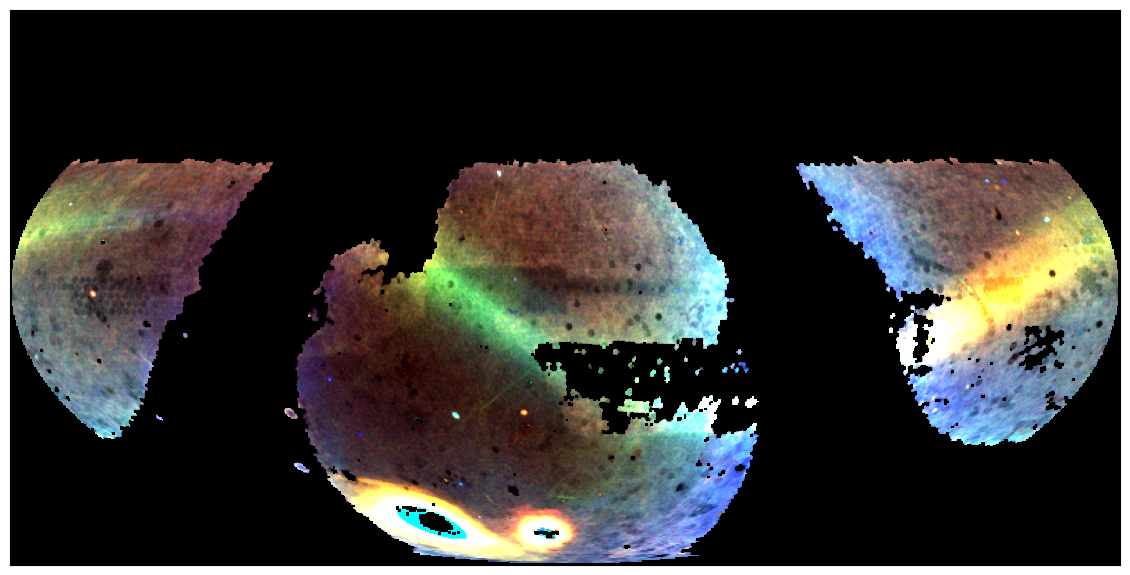

In [255]:
rgb = np.ma.copy(rgb_decals)
rgb = prepare_data.renorm_rgb(rgb, pmin=0.2, pmax=93)

proj = hp.projector.MollweideProj() 
img = np.stack([proj.projmap(rgb[i].filled(np.nan), vec2pix) 
                for i in range(3)], axis=-1)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.imshow(img, origin='lower', extent=proj.get_extent())
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
fig.tight_layout()

plt.savefig('decals_dr10_z%.4f_a%.1f_gmax%.1f.png' %(z, a, gmax), bbox_inches='tight')

In [6]:
import skyproj

def draw_polygon(ax, proj, lon, lat, edgecolor='red', linestyle='solid', facecolor=None, **kwargs):
    """Plot a polygon from a list of lon, lat coordinates.

    This routine is a convenience wrapper around plot() and fill(), both
    of which work in geodesic coordinates.

    Parameters
    ----------
    lon : `np.ndarray`
        Array of longitude points in polygon.
    lat : `np.ndarray`
        Array of latitude points in polygon.
    edgecolor : `str`, optional
        Color of polygon boundary.  Set to None for no boundary.
    linestyle : `str`, optional
        Line style for boundary.
    facecolor : `str`, optional
        Color of polygon face.  Set to None for no fill color.
    **kwargs : `dict`, optional
        Additional keywords passed to plot.
    """
    plt.sca(ax)
    lon, lat = np.append(lon, lon[0]), np.append(lat, lat[0])
    x, y = proj.ang2xy(lon, lat, lonlat=True)
    if linestyle is not None and edgecolor is not None:
        plt.plot(x, y, color=edgecolor, linestyle=linestyle, **kwargs)
    if facecolor is not None:
        plt.fill(x, y, color=facecolor, **kwargs)

def draw_polygon_file(ax, proj, filename, reverse=True, edgecolor='red', linestyle='solid', **kwargs):
    """Draw a text file containing lon, lat coordinates of polygon(s).

    Parameters
    ----------
    filename : `str`
        Name of file containing the polygon(s) [lon, lat, poly]
    reverse : `bool`
        Reverse drawing order of points in each polygon.
    edgecolor : `str`
        Color of polygon boundary.
    linestyle : `str`, optional
        Line style for boundary.
    **kwargs : `dict`
        Additional keywords passed to plot.
    """
    try:
        data = np.genfromtxt(filename, names=['lon', 'lat', 'poly'])
    except ValueError:
        from numpy.lib.recfunctions import append_fields
        data = np.genfromtxt(filename, names=['lon', 'lat'])
        data = append_fields(data, 'poly', np.zeros(len(data)))

    for p in np.unique(data['poly']):
        poly = data[data['poly'] == p]
        lon = poly['lon'][::-1] if reverse else poly['lon']
        lat = poly['lat'][::-1] if reverse else poly['lat']
        draw_polygon(ax,
                     proj,
                     lon,
                     lat,
                     edgecolor=edgecolor,
                     linestyle=linestyle,
                     **kwargs)
        # Only add the label to the first polygon plotting.
        kwargs.pop('label', None)

In [7]:
def get_img(proj, rgb, pmin=0.2, pmax=93):
    rgb = np.ma.copy(rgb)
    rgb = prepare_data.renorm_rgb(rgb, pmin=pmin, pmax=pmax)
    img = np.stack([proj.projmap(rgb[i].filled(np.nan), vec2pix) 
                    for i in range(3)], axis=-1)

    return img

def stack_img(img_list):
    img = img_list[0]
    for im in img_list[1:]:
        idx = np.isfinite(im) & ~np.isnan(im) & (im > 0)
        img[idx] = im[idx]
    return img

In [262]:
im = np.copy(img_des)
idx = np.isfinite(im) & ~np.isnan(im) & (im > 0)
im[idx] = 1.0

In [273]:
# phi, theta, psi = utils.get_euler(ends=[(5, -25), (10, -25)])

33.11311214825894 99.99999999999919
19.952623149688748 33.11311214825894
10.0 19.952623149688748
Rerunning data stack...
Saving data stack ../data/data_stack_decals_dr10_v0_g23.0_bkg0.npy...
33.11311214825894 99.99999999999919
19.952623149688748 33.11311214825894
10.0 19.952623149688748
Rerunning data stack...
Saving data stack ../data/data_stack_des_y6_v0_g24.5_bkg0.npy...


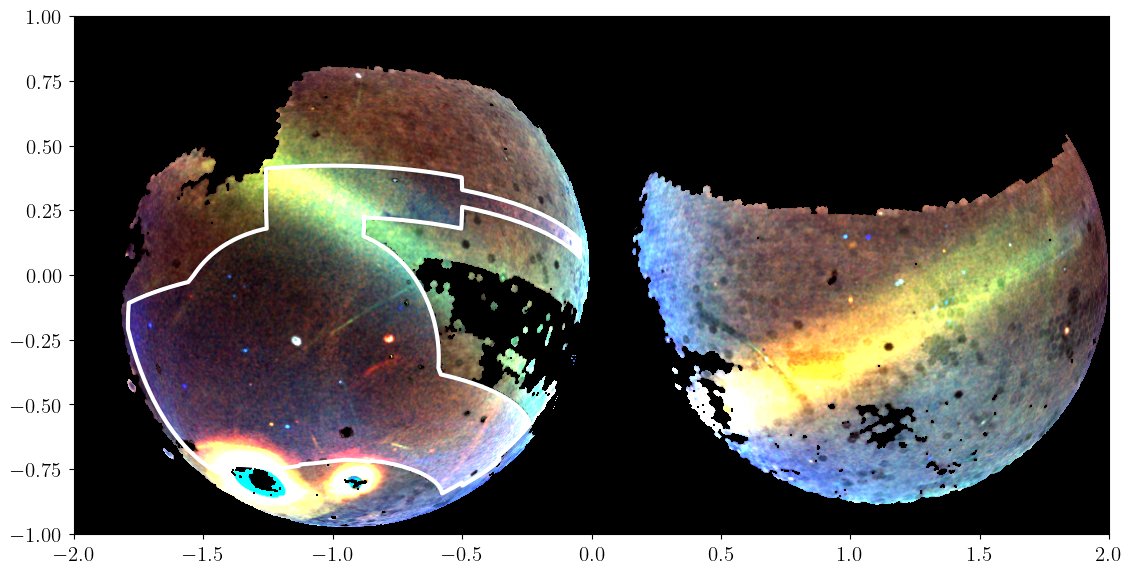

In [274]:
reload(prepare_data)

# proj = hp.projector.MollweideProj() 
proj = hp.projector.OrthographicProj(xsize=1024, rot=[30, -20, 0])

version = 0
if True:
    rgb_decals, data_decals = prepare_data.get_survey_data(hpxcube_decals, fracdet_decals, moduli, survey='DECaLS_DR10', use_bkg=False, version=version, proj=proj, gmax=23.0, rerun=True)
    rgb_des, data_des = prepare_data.get_survey_data(hpxcube_des, fracdet_des, moduli, survey='DES_Y6', use_bkg=False, version=version, proj=proj, gmax=24.5, rerun=True)

img_des = get_img(proj, rgb_des)
img_decals = get_img(proj, rgb_decals)
img = stack_img([img_decals, img_des])

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.imshow(img, origin='lower', extent=proj.get_extent())
# ax.imshow(img_decals, origin='lower', extent=proj.get_extent())
# ax.imshow(img_des, origin='lower', extent=proj.get_extent())
draw_polygon_file(ax, proj, filename='../data/footprints/des-round19-poly.txt', edgecolor='w', lw=3)

# hp.visufunc.projplot(-30,-30, 'r*', ms=200, lonlat=True)
# x, y = proj.ang2xy(-30,-30, lonlat=True)
# ax.plot(x, y, 'r*', ms=20)

# ax.xaxis.set_visible(False)
# ax.yaxis.set_visible(False)
fig.tight_layout()

# Rotating Sphere

In [55]:
import plotly

In [56]:
def degree2radians(degree):
  # convert degrees to radians
  return degree*np.pi/180
  
def mapping_map_to_sphere(lon, lat, radius=1):
  # this function maps the points of coords (lon, lat) to points onto the sphere of radius radius
  lon=np.array(lon, dtype=np.float64)
  lat=np.array(lat, dtype=np.float64)
  lon=degree2radians(lon)
  lat=degree2radians(lat)
  xs=radius*np.cos(lon)*np.cos(lat)
  ys=radius*np.sin(lon)*np.cos(lat)
  zs=radius*np.sin(lat)
  return xs, ys, zs

In [57]:
hpx_slice = np.copy(hpxcube_des[:,np.argmin(np.abs(moduli_des - 16.0))])
# hpx_slice = utils.apwnorm(hpx_slice, 0, 1)

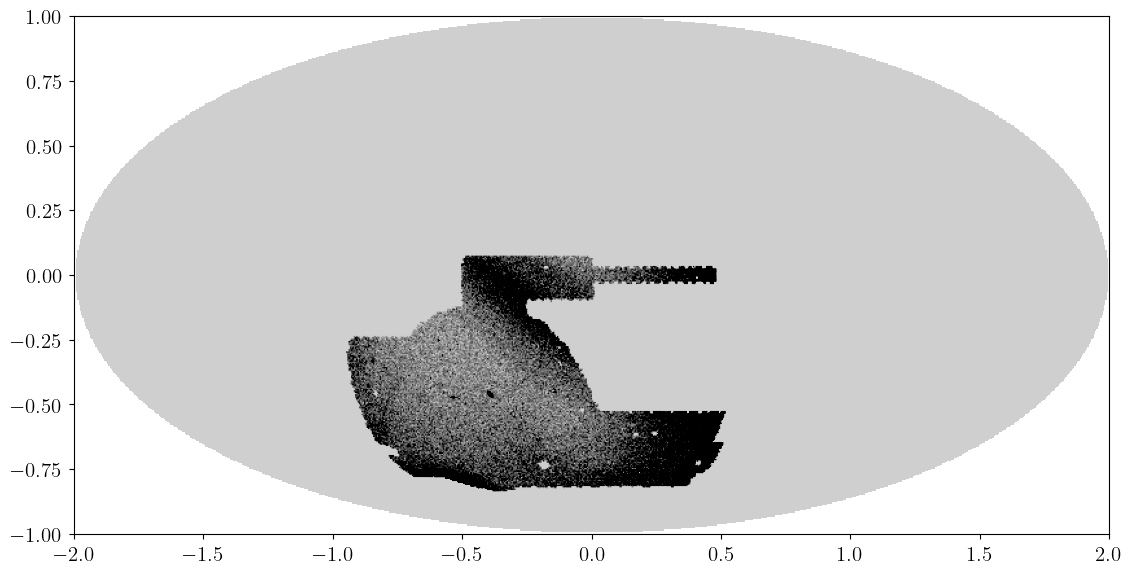

In [58]:
proj = hp.projector.MollweideProj() 
ax, im = plot_density_healpy.plot_proj(proj, hpx_slice, vmin=-5, vmax=12)

In [59]:
import healpy as hp
hpx_slice = hp.pixelfunc.ud_grade(hpx_slice, nside_out=128)

In [60]:
hlon, hlat = hp.pix2ang(nside, np.arange(hpx_slice.size), lonlat=True)
idx = np.where(hlon > 0)[0]
len(idx)

196608

In [61]:
# lon = np.linspace(-180, 180, 100)
# lat = np.linspace(-90, 90, 100)
# lon, lat = np.meshgrid(lon, lat)

In [62]:
# from astropy.coordinates import angular_separation

# for i in range(surface.shape[0]):
#     for j in range(surface.shape[1]):
#         dist = angular_separation(lon[i][j], lat[i][j], hlon, hlat)
#         surface[i][j] = hpx_slice[np.argmin(np.abs(dist))]

In [63]:
# xs, ys, zs = mapping_map_to_sphere(lon, lat)

In [48]:
topo_sphere=dict(type='surface',
  x=xs,
  y=ys,
  z=zs,
  colorscale='Greys',
  surfacecolor=surface, # np.ones_like(xs), # hpx_slice,
  cmin=0,
  cmax=1)

noaxis=dict(showbackground=False,
  showgrid=False,
  showline=False,
  showticklabels=False,
  ticks='',
  title='',
  zeroline=False)

import plotly.graph_objs as go

titlecolor = 'white'
bgcolor = 'black'

layout = go.Layout(
  autosize=False, width=1200, height=800,
  title = 'Field of Streams',
  titlefont = dict(family='Courier New', color=titlecolor),
  showlegend = False,
  scene = dict(
    xaxis = noaxis,
    yaxis = noaxis,
    zaxis = noaxis,
    aspectmode='manual',
    aspectratio=go.layout.scene.Aspectratio(
      x=1, y=1, z=1)),
  paper_bgcolor = bgcolor,
  plot_bgcolor = bgcolor)

In [49]:
from plotly.offline import plot

plot_data=[topo_sphere]
fig = go.Figure(data=plot_data) # , layout=layout)
plot(fig, validate = False, filename='SphericalFoS.html', auto_open=True)

'SphericalFoS.html'

In [65]:
hlon.shape, hlat.shape, hpx_slice.shape

((196608,), (196608,), (196608,))

In [66]:
# # Create a trace with spherical mapping
# sphere = go.Scattergeo(
#     lon=hlon,
#     lat=hlat,
#     mode='markers',
#     marker=dict(size=5, color=hpx_slice, colorscale='Viridis', showscale=True)
# )
# # Define the layout for a spherical projection
# layout = go.Layout(
#     title='Interactive Sphere with HEALPix Data',
#     geo=dict(
#         projection_type='orthographic',
#         showland=True,
#         landcolor='white',
#         showocean=True,
#         oceancolor='MidnightBlue'
#     )
# )
# # Create the figure and display
# fig = go.Figure(data=[sphere], layout=layout)
# fig.show()